In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
%load_ext autoreload
%autoreload 2
from src.config import get_spark
from src.utils import spark_utils, metrics
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [2]:
spark = get_spark('FraudDetectionEvaluation')

In [3]:
train_final = spark.read.parquet('../data_processed/train_final.parquet')
test_final = spark.read.parquet('../data_processed/test_final.parquet')
model_cv = PipelineModel.load('../models/model_cv')
model_final = PipelineModel.load('../models/model_final')

In [15]:
# 最终预测
final_predict = model_final.transform(test_final)
final_predict_df = final_predict.select('probability', 'label', 'isFlaggedFraud').toPandas()
y_true = final_predict_df['label'].values
y_proba = final_predict_df['probability'].apply(lambda x: float(x[1])).values
y_flagged = final_predict_df['isFlaggedFraud'].values

用hold_out方法选阈值：  
策略1：让F1最大化 （综合最优）  
策略2：在保证precision>90%的前提下，尽可能提高recall (适合误判成本高场景)  
策略3：在保证recall>90%的前提下，尽可能提高precision （适合漏判成本高场景）

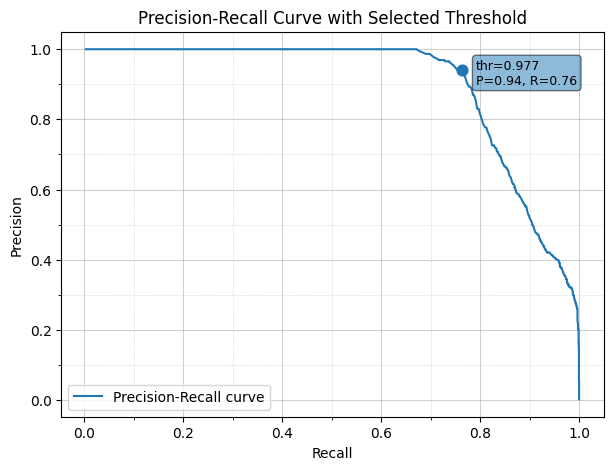

Best threshold: 0.9765017966464375
Precision at best threshold: 0.9406350667280258
Recall at best threshold: 0.7638266068759342


In [5]:
# 策略1：让F1最大化
thre_1 = spark_utils.hold_out_threshold(train_final, model_cv, plot=True)

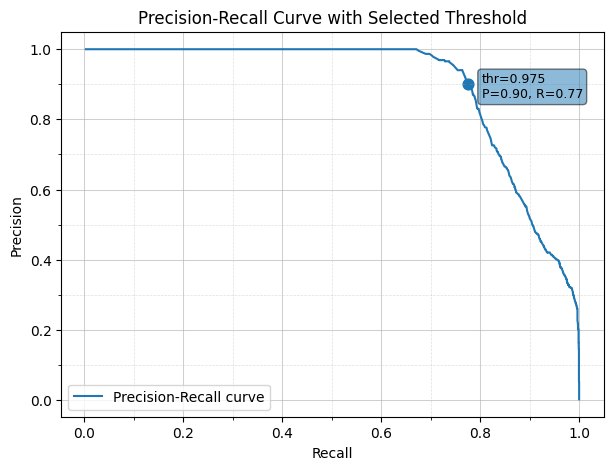

Best threshold: 0.9752265434701327
Precision at best threshold: 0.9009126466753585
Recall at best threshold: 0.7746636771300448


In [6]:
# 策略2：在保证precision>90%的前提下，尽可能提高recall
thre_2 = spark_utils.hold_out_threshold(train_final, model_cv, tp=0.9, priority='recall', plot=True)

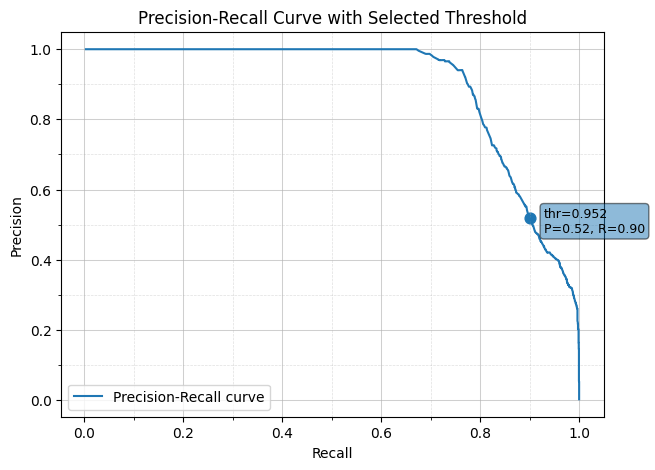

Best threshold: 0.9522321089691265
Precision at best threshold: 0.5177228786251342
Recall at best threshold: 0.9005979073243647


In [7]:
# 策略3：在保证recall>90%的前提下，尽可能提高precision
thre_3 = spark_utils.hold_out_threshold(train_final, model_cv, tr=0.9, priority='precision', plot=True)

In [8]:
y_pred_1 = metrics.evaluate_threshold(y_true, y_proba, threshold=thre_1)


📊 Model Evaluation at Threshold = 0.977


,Score
Threshold,0.976502
Accuracy,99.621523
Precision,98.709677
Recall,76.500000
F1,86.197183
ROC-AUC,99.937054
PR-AUC,96.530118



Confusion Matrix:
[[101957     16]
 [   376   1224]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9963    0.9998    0.9981    101973
         1.0     0.9871    0.7650    0.8620      1600

    accuracy                         0.9962    103573
   macro avg     0.9917    0.8824    0.9300    103573
weighted avg     0.9962    0.9962    0.9960    103573



In [9]:
y_pred_2 = metrics.evaluate_threshold(y_true, y_proba, threshold=thre_2)


📊 Model Evaluation at Threshold = 0.975


,Score
Threshold,0.975227
Accuracy,99.620557
Precision,98.473896
Recall,76.625000
F1,86.186292
ROC-AUC,99.937054
PR-AUC,96.530118



Confusion Matrix:
[[101954     19]
 [   374   1226]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9963    0.9998    0.9981    101973
         1.0     0.9847    0.7662    0.8619      1600

    accuracy                         0.9962    103573
   macro avg     0.9905    0.8830    0.9300    103573
weighted avg     0.9962    0.9962    0.9960    103573



In [10]:
y_pred_3 = metrics.evaluate_threshold(y_true, y_proba, threshold=thre_3)


📊 Model Evaluation at Threshold = 0.952


,Score
Threshold,0.952232
Accuracy,99.544283
Precision,80.192719
Recall,93.625000
F1,86.389850
ROC-AUC,99.937054
PR-AUC,96.530118



Confusion Matrix:
[[101603    370]
 [   102   1498]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9990    0.9964    0.9977    101973
         1.0     0.8019    0.9363    0.8639      1600

    accuracy                         0.9954    103573
   macro avg     0.9005    0.9663    0.9308    103573
weighted avg     0.9960    0.9954    0.9956    103573



本次欺诈检测模型的整体表现非常优秀。模型在测试集上取得了 **PR-AUC ≈ 0.965** 的成绩，说明其对正负样本的区分能力极强。通过不同阈值的策略对比，模型在精确率（Precision）与召回率（Recall）之间呈现出典型的高精度—低召回权衡关系。当前模型在 PR-AUC 达到 0.965 的情况下，说明其仍能在稀少的正样本中保持高识别能力，是一个在精度与覆盖率上均处于优质水平的模型。

在 **策略 1（F1 最大化） 与 策略 2（Precision ≥ 90% 前提下 Recall 最大化）** 中，模型的阈值分别约为 0.977 与 0.975，表现几乎一致：Precision ≈ 98.7%、Recall ≈ 76.5%，F1 ≈ 86。这类阈值对应的模型输出极为保守，仅在高度确信样本为欺诈时才标记为正类。其优点是误报率极低（正常用户几乎不会被误判），非常适用于对业务影响较大的自动拦截或拒绝交易场景。此类高精度模型可显著降低人工复核成本，保证业务体验稳定，但也意味着仍有部分真实欺诈未被捕获。

在 **策略 3（Recall ≥ 90% 前提下 Precision 最大化）** 中，阈值下降至约 0.952，模型召回率提升至 93.6%，而精确率下降至约 80.2%，F1 基本保持不变。这种阈值下模型更为“激进”，能捕获更多潜在欺诈样本，但同时引入了更多误报。该策略适合风控预警或人工审核名单场景，可以防止遗漏高风险交易。

总体而言，该模型在 **排序能力、可解释性及可调节性** 上均表现出色。不同阈值可灵活适配不同业务目标：  
若追求低误报、业务稳定，可采用 0.975–0.977 的高精度阈值；  
若追求高召回、尽量减少漏判，可采用 0.952 的高召回阈值。

In [11]:
assembler = [s for s in model_final.stages if isinstance(s, VectorAssembler)][0]
feature_cols  = assembler.getInputCols()
importances = model_final.stages[-1].featureImportances.toArray()
feature_importances = pd.DataFrame({'feature': feature_cols, 'importance': importances}).sort_values('importance', ascending=False)

In [12]:
feature_importances

,feature,importance
0,type_idx,3.660284e-01
5,oldbalanceOrg_log,3.238054e-01
4,amount_log,2.206044e-01
3,newbalanceOrig_isZero,4.435450e-02
7,newbalanceDest_log,3.272536e-02
6,oldbalanceDest_log,1.248198e-02
1,nameOrig__X__nameDest_idx,5.823764e-16
2,nameOrig__X__nameDest__X__type_idx,0.000000e+00


模型的特征重要性结果显示，不同类型的变量在欺诈检测任务中的贡献差异明显，
其中 交易类型 (type_idx)、原账户余额 (oldbalanceOrg_log) 和 交易金额 (amount_log) 是模型最关键的特征，合计占据了约 90% 的总重要性。
这表明模型主要依赖交易结构类信号（Transaction-level Features）来区分正常与异常交易。

在次要层面，账户余额变化模式 特征如 newbalanceOrig_isZero 与 newbalanceDest_log 也具有一定贡献（约 4% 和 3%），
说明模型能够识别“转出账户清空”“资金归零”等异常行为模式，这些特征在欺诈检测领域具有明确的业务意义。

相比之下，部分人工构造的交叉特征（例如 nameOrig_X_nameDest_idx、nameOrig_X_nameDest_X_type_i）的重要性极低（接近 0），
这表明 GBT 模型已经能够自动学习变量间的非线性与交互关系，不再需要显式的特征组合。

In [22]:
print(metrics.compare_models(y_true, y_pred_1, y_flagged))

           New model  Old Model
Precision   0.987097   1.000000
Recall      0.765000   0.005000
F1          0.861972   0.009950
Accuracy    0.996215   0.984629


In [23]:
print(metrics.compare_models(y_true, y_pred_2, y_flagged))

           New model  Old Model
Precision   0.984739   1.000000
Recall      0.766250   0.005000
F1          0.861863   0.009950
Accuracy    0.996206   0.984629


In [25]:
print(metrics.compare_models(y_true, y_pred_3, y_flagged))

           New model  Old Model
Precision   0.801927   1.000000
Recall      0.936250   0.005000
F1          0.863899   0.009950
Accuracy    0.995443   0.984629


以上是3种策略和老模型的分数评估结果。因老模型精确率（precision）为1，判断这是一个高精确度场景，因此我们使用相同的策略（2）进行比较。  

相比于旧规则系统，新模型在几乎所有关键指标上均实现了显著提升。虽然旧模型在精确率上理论上达到1.0，但这并非代表模型更优，而是因为其极度保守，仅在极少数情况下标记欺诈，从而导致召回率（Recall）极低，仅为 0.5%。换句话说，旧模型几乎 “只在完全确定时才报 Fraud”，错过了绝大部分真实风险样本。

新模型通过基于样本学习的决策边界与参数优化机制，实现了更高的综合性能：  
Recall 从 0.005 提升至 0.765，能识别约 76.5% 的真实欺诈样本；  
F1 从 0.0099 提升至 0.862，综合能力提升近 86 倍；  
Accuracy 提升约 1.2 个百分点，但更重要的是模型在极度样本不平衡场景下仍保持了高精度。